# Import functions for all processing
Put this notebook inside passive_interval_oddball_202412 project folder. The fllowing is the same as main.py at the beginning.

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

import gc
import os
import argparse
from datetime import datetime

from modules import Trialization
from modules.ReadResults import read_ops

def combine_session_config_list(session_config_list):
    list_session_data_path = []
    for sc in session_config_list['list_config']:
        list_session_data_path += [
            os.path.join('results', sc['session_folder'], n)
            for n in sc['list_session_name'].keys()]
    list_session_name = [sc['list_session_name'] for sc in session_config_list['list_config']]
    list_session_name = {k: v for d in list_session_name for k, v in d.items()}
    session_config_list['list_session_name'] = list_session_name
    session_config_list['list_session_data_path'] = list_session_data_path
    return session_config_list

# Define the folder name to the sessions you want to process

## Folder structure

This notebook should be SomeWhere/passive_interval_oddball_202412/quick_start.ipynb.

The data should be SomeWhere/passive_interval_oddball_202412/SubjectName/SessionName.

In this example, we use 1 session from the random paradigm, and the session data is SomeWhere/passive_interval_oddball_202412/test/VTYH02_PPC_20250109_3331Random.

## How to set the sessions going into the analysis

Change list_session_name elements in session_config_test to add or exclude sessions. No need to change anything else at this time.

## It works for both single and cross subject analysis

Here, session_config_test is for cross subject analysis, while session_config_list_test specify the info for one subject. If you are running single subject analysis, list_config in session_config_list_test should have only 1 element for that subject.

## Using short long session as example below

In [2]:
session_config_test = {
        'list_session_name' : {
            'YH18VT_V1_20250417_1451ShortLong' : 'short_long',
            'YH18VT_V1_20250418_1451ShortLong' : 'short_long',
            'YH18VT_V1_20250421_1451ShortLong' : 'short_long',
            },
        'session_folder' : 'YH18VT',
        'sig_tag' : 'all',
        'force_label' : None,
        }
session_config_list_test = {
    'list_config': [
        session_config_test,
        ],
    'label_names' : {
        '-1':'Exc',
        '1':'Inh_VIP',
        '2':'Inh_SST',
        },
    'subject_name' : 'YH18VT',
    'output_filename' : 'YH18VT_PPC_passive.html'
    }

Read all saved processsed results.

Set other useful variables.

In [3]:
cate_list = [[-1,1,2]]

import matplotlib.pyplot as plt

label_names = {'-1':'Exc', '1':'Inh_VIP', '2':'Inh_SST'}
cate = [-1,1,2]
roi_id = None
norm_mode='none'
cluster_cmap = plt.cm.hsv
standard = 1
oddball = 1
block = 0
mode = 'post'
temp_folder = 'temp_'+session_config_list_test['subject_name']
if not os.path.exists(os.path.join('results', 'temp_'+session_config_list_test['subject_name'])):
    os.makedirs(os.path.join('results', 'temp_'+session_config_list_test['subject_name']))

Run this to get session configurations. There is only 1 session so the list will have only 1 element. The list structure is using for cross session or cross subject settings.

In [4]:
session_config_list = combine_session_config_list(session_config_list_test)
list_ops = read_ops(session_config_list['list_session_data_path'])
print(session_config_list)
print(f'number of sessions: {len(list_ops)}')

{'list_config': [{'list_session_name': {'YH18VT_V1_20250417_1451ShortLong': 'short_long', 'YH18VT_V1_20250418_1451ShortLong': 'short_long', 'YH18VT_V1_20250421_1451ShortLong': 'short_long'}, 'session_folder': 'YH18VT', 'sig_tag': 'all', 'force_label': None}], 'label_names': {'-1': 'Exc', '1': 'Inh_VIP', '2': 'Inh_SST'}, 'subject_name': 'YH18VT', 'output_filename': 'YH18VT_PPC_passive.html', 'list_session_name': {'YH18VT_V1_20250417_1451ShortLong': 'short_long', 'YH18VT_V1_20250418_1451ShortLong': 'short_long', 'YH18VT_V1_20250421_1451ShortLong': 'short_long'}, 'list_session_data_path': ['results\\YH18VT\\YH18VT_V1_20250417_1451ShortLong', 'results\\YH18VT\\YH18VT_V1_20250418_1451ShortLong', 'results\\YH18VT\\YH18VT_V1_20250421_1451ShortLong']}
number of sessions: 3


# Reading data results

Run the following to do trialization if it is not done yet. Otherwise, you can skip this.

In [5]:
for i in range(len(list_ops)):
    Trialization.run(list_ops[i])

Reading dff traces and voltage recordings
Correcting 2p camera trigger time
Saving trial data
Reading dff traces and voltage recordings
Correcting 2p camera trigger time
Saving trial data
Reading dff traces and voltage recordings
Correcting 2p camera trigger time
Saving trial data


Now you can read all results for analysis as follows. If you want to smooth the trace, set smooth=True instead.

In [6]:
from modules.ReadResults import read_all
[list_labels, list_masks,list_neural_trials, list_move_offset] = read_all(session_config_list, smooth=False)

Reading subject 1/1


100%|████████████████████████████████████████████| 3/3 [00:00<00:00,  5.02it/s]


# Define utility functions

All the following codes are drawed from utils.py. No need to go through the details.



In [20]:
# rescale voltage recordings.
def rescale(data, upper, lower):
    data = data.copy()
    data = ( data - np.nanmin(data) ) / (np.nanmax(data) - np.nanmin(data))
    data = data * (upper - lower) + lower
    return data

# compute mean and sem for 3d array data.
def get_mean_sem(data, win_baseline=None):
    # compute mean.
    m = np.nanmean(data.reshape(-1, data.shape[-1]), axis=0)
    # compute sem.
    std = np.nanstd(data.reshape(-1, data.shape[-1]), axis=0)
    count = np.nansum(~np.isnan(data.reshape(-1, data.shape[-1])), axis=0)
    s = std / np.sqrt(count)
    return m, s

def plot_mean_sem(ax, t, m, s, c, l=None, a=1.0):
    ax.plot(t, m, color=c, label=l, alpha=a)
    ax.fill_between(t, m - s, m + s, color=c, alpha=0.25, edgecolor='none')
    ax.set_xlim([np.min(t), np.max(t)])

def plot_pupil(ax, nt, cp, c, u, l):
    cp = rescale(cp, u, l)
    ax.plot(nt, cp, color=c)

# Neural data alignment

We are using classes for modularizations. All the following codes are drawed from fig5_1451ShortLong.py.

## Import functions and run alignment

This is the same when initiating a plotter class.

In [8]:
import traceback
import numpy as np
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import savgol_filter

from modules.Alignment import run_get_stim_response
from modeling.clustering import get_mean_sem_cluster
from modeling.clustering import get_cluster_cate
from modeling.decoding import decoding_time_confusion
from modeling.decoding import decoding_time_single
from modeling.decoding import regression_time_frac
from modeling.generative import get_glm_cate
from modeling.quantifications import fit_trf_model

from utils import norm01
from utils import show_resource_usage
from utils import get_norm01_params
from utils import get_odd_stim_prepost_idx
from utils import get_mean_sem_win
from utils import get_mean_sem
from utils import get_neu_trial
from utils import get_frame_idx_from_time
from utils import get_split_idx
from utils import get_expect_interval
from utils import get_block_1st_idx
from utils import get_block_transition_idx
from utils import exclude_odd_stim
from utils import get_temporal_scaling_data
from utils import get_cmap_color
from utils import hide_all_axis
from utils import get_random_rotate_mat_3d
from utils import adjust_layout_isi_example_epoch
from utils import adjust_layout_neu
from utils import adjust_layout_3d_latent
from utils import add_legend
from utils import add_heatmap_colorbar
from utils import utils_basic

n_sess = len(list_neural_trials)
alignment = run_get_stim_response(temp_folder, list_neural_trials, expected='none')
list_stim_labels = alignment['list_stim_labels']
list_odd_idx = [
    get_odd_stim_prepost_idx(sl) for sl in list_stim_labels]
expect = np.nanmin(np.array([get_expect_interval(sl) for sl in list_stim_labels]),axis=0)
list_block_start = [get_block_1st_idx(sl, 3) for sl in list_stim_labels]
bin_win = [450,2550]
bin_num = 2
d_latent = 3

Aligning trials for session 1/3


trials: 100%|███████████████████████████| 1990/1990 [00:00<00:00, 21420.54it/s]


Aligning trials for session 2/3


trials: 100%|███████████████████████████| 1990/1990 [00:00<00:00, 21233.31it/s]


Aligning trials for session 3/3


trials: 100%|███████████████████████████| 1990/1990 [00:00<00:00, 21726.77it/s]


All the trialized neural data are in alignment. It has the following keys to access. Each element in alignment is a list. This list has the results for multiple sessions. 

### Neural data
list_neu_seq is the neural data after alignment on each image onset. It has l_frames before the onset and r_frames after onset. Each element in this list represents 1 session, and has the shape of $n_{trials} \times n_{neurons} \times n_{times}$.

neu_time is the time stamps of the neural data with the shape of $n_{times}$.

In [9]:
print('shape of aligned neural data in a session: {}'.format([lns.shape for lns in alignment['list_neu_seq']]))
print('shape of aligned neural timestamps in a session: {}'.format(alignment['neu_time'].shape))

shape of aligned neural data in a session: [(1990, 200, 600), (1990, 254, 600), (1990, 116, 600)]
shape of aligned neural timestamps in a session: (600,)


### Image trial data

list_stim_labels is for accessing trial specific neural data. It marks the information for each image (trial). Each row represents 1 image.

* row 0: stim start.
* row 1: stim end.
* row 2: img_seq_label.
* row 3: standard_types.
* row 4: fix_jitter_types.
* row 5: oddball_types.
* row 6: random_types.
* row 7: opto_types.

Now show the first 5 image here.

In [10]:
print(alignment['list_stim_labels'][0][:5,:])

[[29937 30135     5     0     1     0     1     0]
 [31937 32135     5     0     1     0     1     0]
 [34470 34669     4     0     1     0     1     0]
 [35870 36069     2     0     1     0     1     0]
 [36870 37069     4     0     1     0     1     0]]


The stimulus timing for one trial has been already proceesed in list_stim_seq. It has multiple stimulus onset and end before and after the alignment center after trial averaged.

Now show the stimulus timing for the 5th aligned trial. 

In [11]:
print(alignment['list_stim_seq'][0][5,:])

[[-8400 -8202]
 [-6400 -6202]
 [-3867 -3668]
 [-2467 -2268]
 [-1467 -1268]
 [    0   198]
 [ 1200  1398]
 [ 2933  3132]
 [ 3800  3998]
 [ 5933  6132]
 [ 6933  7132]]


The center stimulus index for alignment can be accessed similar as the following. By setting the number around c_idx you can access stimulus before or after it.

In [12]:
stim_seq = alignment['list_stim_seq'][0][5,:]
c_idx = int(stim_seq.shape[0]/2)
print('onset and end of the aligned stimulus: {}'.format(stim_seq[c_idx,:]))
print('onset and end of the stimlus before center: {}'.format(stim_seq[c_idx-1,:]))
print('onset and end of the stimulus after center: {}'.format(stim_seq[c_idx+1,:]))

onset and end of the aligned stimulus: [  0 198]
onset and end of the stimlus before center: [-1467 -1268]
onset and end of the stimulus after center: [1200 1398]


list_pre_isi is the interval between the center image and the one before it.

Now show the interval before the 5th alignment stimulus.

In [13]:
print('isi before image: {}'.format(alignment['list_pre_isi'][0][5]))

isi before image: 1268


## Accessing trial averaged data

Use get_neu_trial defined in passive_interval_oddball_202412/utils.py to access trials with specific trial labels. Set cate to the neuron categories as a list, and the trial label as a list. Note that get_neu_trial is the main function to access individual trials for all neurons. The main flexibility of it is specified by these inputs:
1. trial_idx=None: If you know the exact indices of the trials (e.g., block transition analysis), replace it here. By default, this is usually not used.
2. trial_param=None: This is the main input to collect trial results. Details as follows.
3. mean_sem=True: Whether return single trial data or return trial averaged concatenated data.
4. sub_sampling=False: Whehter use boostrapping for subsampling the trials to construct pseudo trial data, useful for decoding.

The list input trial_param is the one to access each trial, where each element gives what are the target label for list_labels. For example, the following input [[2,3,4,5], None, None, None, [1], [0]] means:
* all 4 image orientation defined in img_seq_label.
* no need to set standard_types.
* no need to set fix_jitter_types.
* no need to set oddball_types.
* image with random isi and random image.
* no opto.

Now show the trial for all neurons averaged during short and long isi. Be advised, in this setting, the neural data has been averaged across trials and concatenate across sessions.

In [14]:
[_, [neu_seq_0, _, stim_seq_0, camera_pupil_0], _, _] = get_neu_trial(
    alignment, list_labels, list_stim_labels,
    trial_param=[[2,3,4,5], [0], None, None, [0], [0]],
    cate=cate, roi_id=None)
[_, [neu_seq_1, _, stim_seq_1, camera_pupil_1], _, _] = get_neu_trial(
    alignment, list_labels, list_stim_labels,
    trial_param=[[2,3,4,5], [1], None, None, [0], [0]],
    cate=cate, roi_id=None)

neu_seq gives the target neural data with the shape of $n_{neurons} \times n_{times}$.

In [15]:
print('shape of neural data during short isi: {}'.format(neu_seq_0.shape))
print('shape of neural data during long isi: {}'.format(neu_seq_1.shape))

shape of neural data during short isi: (487, 600)
shape of neural data during long isi: (487, 600)


In [16]:
print('shape of pupil data during short isi: {}'.format(camera_pupil_0.shape))
print('shape of pupil data during long isi: {}'.format(camera_pupil_1.shape))

shape of pupil data during short isi: (600,)
shape of pupil data during long isi: (600,)


Now plot the response during short and long isi respectively. It is trial averaged, and shows mean/sem across all neurons.

To access the neural data within a given window, please use get_frame_idx_from_time. It gives you the start and end indice given a window. The function inputs are the time stamp array, the center reference time point, time before the reference, the time after the reference.

Now get the same result but across all neurons within $[-2500, 2000]$ ms, so set the center to $0$, the time before to $-1500$, the time after to $1000$.

In [17]:
win_eval = [-2500, 2000]
l_idx, r_idx = get_frame_idx_from_time(alignment['neu_time'], 0, win_eval[0], win_eval[1])
neu_seq_win_0 = neu_seq_0[:,l_idx:r_idx]
neu_seq_win_1 = neu_seq_1[:,l_idx:r_idx]
neu_time_win = alignment['neu_time'][l_idx:r_idx]
print('shape of neural data within the window (short block): {}'.format(neu_seq_win_0.shape))
print('shape of neural data within the window (long block): {}'.format(neu_seq_win_1.shape))

shape of neural data within the window (short block): (487, 134)
shape of neural data within the window (long block): (487, 134)


Almost all plots about averaged traces follow the same logic as:
1. Find average across neurons with get_mean_sem.
2. Find the upper and lower bounds of the mean responses.
3. Plot the stimulus timing with fill_between.
4. Plot the neural responses with plot_mean_sem.
5. Ajust the overall layout based on adjust_layout_neu.

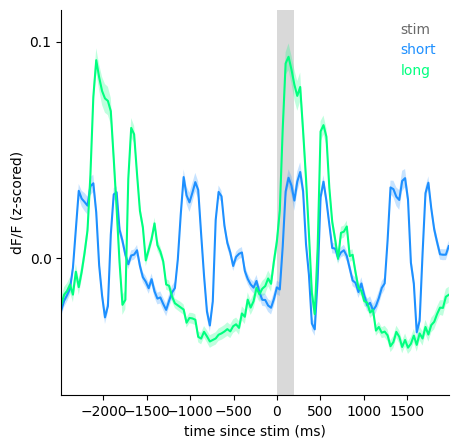

In [18]:
color0 = 'dimgrey'
color1 = 'dodgerblue'
color2 = 'springgreen'

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

mean_0, sem_0 = get_mean_sem(neu_seq_win_0)
mean_1, sem_1 = get_mean_sem(neu_seq_win_1)
# compute bounds.
upper = np.nanmax([mean_0, mean_1]) + np.nanmax([sem_0, sem_1])
lower = np.nanmin([mean_0, mean_1]) - np.nanmax([sem_0, sem_1])
# plot stimulus.
ax.fill_between(
    stim_seq[int(stim_seq.shape[0]/2),:],
    lower - 0.1*(upper-lower), upper + 0.1*(upper-lower),
    color=color0, edgecolor='none', alpha=0.25, step='mid')
# plot neural traces.
plot_mean_sem(ax, neu_time_win, mean_0, sem_0, color1, None)
plot_mean_sem(ax, neu_time_win, mean_1, sem_1, color2, None)
# adjust layout.
adjust_layout_neu(ax)
ax.set_ylim([lower - 0.1*(upper-lower), upper + 0.1*(upper-lower)])
ax.set_xlabel('time since stim (ms)')
add_legend(ax, [color0, color1, color2], ['stim', 'short', 'long'], None, None, None, 'upper right')

plt.show()

# Pupil alignment

Now plot the same trial averaged but for pupil trace.

Text(0, 0.5, 'pupil area')

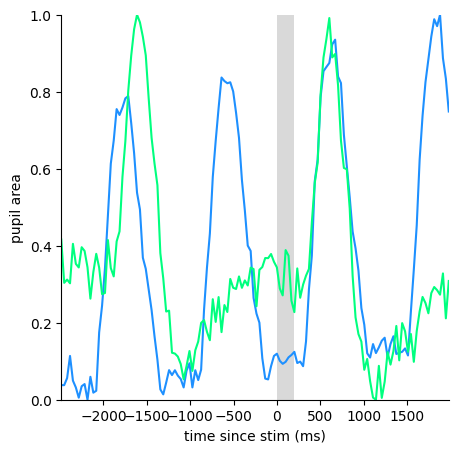

In [24]:
cp_0 = camera_pupil_0[l_idx:r_idx]
cp_1 = camera_pupil_1[l_idx:r_idx]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.fill_between(
    stim_seq_0[int(stim_seq_0.shape[0]/2),:],
    0, 1,
    color=color0, edgecolor='none', alpha=0.25, step='mid')
plot_pupil(ax, neu_time_win, cp_0, color1, 0, 1)
plot_pupil(ax, neu_time_win, cp_1, color2, 0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([neu_time_win[0], neu_time_win[-1]])
ax.set_ylim([0, 1])
ax.set_xlabel('time since stim (ms)')
ax.set_ylabel('pupil area')

Now plot the same trial averaged pupil trace but during block transition. Instead of accessing trials with trial_param, we use trial_idx and compute the index beforehand.

In [26]:
trials_around = 40
# get transition trials indice.
list_trans_0to1 = [get_block_transition_idx(sl[:,3], trials_around)[0] for sl in list_stim_labels]
list_trans_1to0 = [get_block_transition_idx(sl[:,3], trials_around)[1] for sl in list_stim_labels]
list_trans_0to1 = [np.nansum(ti, axis=0).astype('bool') for ti in list_trans_0to1]
list_trans_1to0 = [np.nansum(ti, axis=0).astype('bool') for ti in list_trans_1to0]

In [44]:
xlim = [-7500, 7000]
l_idx, r_idx = get_frame_idx_from_time(alignment['neu_time'], 0, xlim[0], xlim[1])
# collect data.
[_, [_, _, stim_seq_0to1, camera_pupil_0to1], _, _] = get_neu_trial(
    alignment, list_labels, list_stim_labels,
    trial_idx=[l[1] for l in list_block_start],
    cate=cate, roi_id=None)
[_, [_, _, stim_seq_1to0, camera_pupil_1to0], _, _] = get_neu_trial(
    alignment, list_labels, list_stim_labels,
    trial_idx=[l[0] for l in list_block_start],
    cate=cate, roi_id=None)

neu_time = alignment['neu_time'][l_idx:r_idx]
camera_pupil_0to1 = camera_pupil_0to1[l_idx:r_idx]
camera_pupil_1to0 = camera_pupil_1to0[l_idx:r_idx]
print(f'shape of timestamp: {neu_time.shape}')
print(f'shape of pupil data during short to long transition: {camera_pupil_0to1.shape}')
print(f'shape of pupil data during long to short transition: {camera_pupil_1to0.shape}')

shape of timestamp: (432,)
shape of pupil data during short to long transition: (432,)
shape of pupil data during long to short transition: (432,)


Text(0.5, 1.0, 'L→S adaptation')

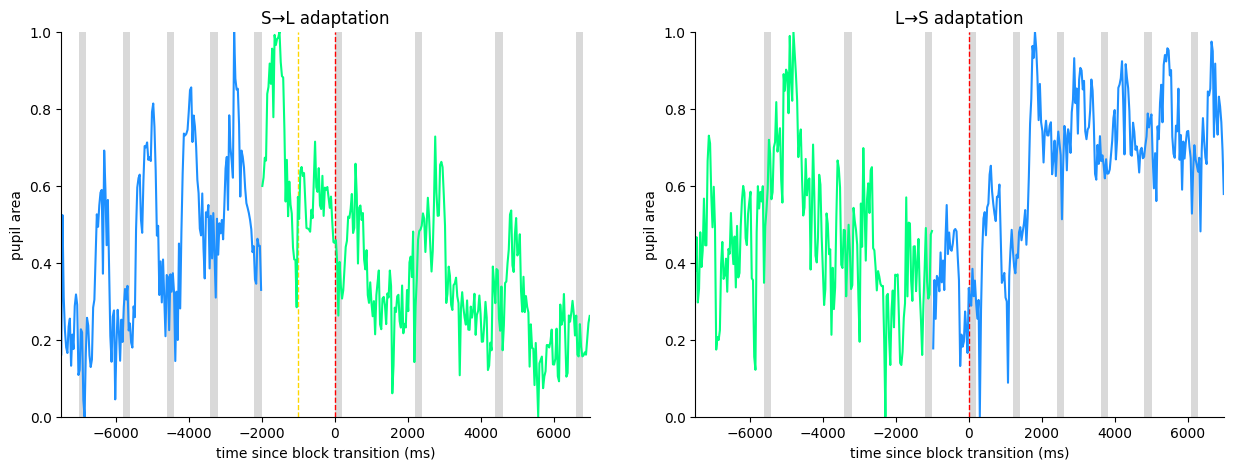

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# plot stimulus.
for si in range(stim_seq_0to1.shape[0]):
    axs[0].fill_between(
        stim_seq_0to1[si,:],
        0, 1,
        color=color0, edgecolor='none', alpha=0.25, step='mid')
    axs[1].fill_between(
        stim_seq_1to0[si,:],
        0, 1,
        color=color0, edgecolor='none', alpha=0.25, step='mid')
axs[0].axvline(-expect[0], color='gold', lw=1, linestyle='--')
axs[0].axvline(0, color='red', lw=1, linestyle='--')
axs[1].axvline(0, color='red', lw=1, linestyle='--')

z_idx_0 = get_frame_idx_from_time(neu_time, 0, stim_seq_1to0[c_idx-1,1], 0)[0]
z_idx_1 = get_frame_idx_from_time(neu_time, 0, stim_seq_0to1[c_idx-1,1], 0)[0]

plot_pupil(axs[0], neu_time[:z_idx_1], camera_pupil_0to1[:z_idx_1], color1, 0, 1)
plot_pupil(axs[0], neu_time[z_idx_1:], camera_pupil_0to1[z_idx_1:], color2, 0, 1)
plot_pupil(axs[1], neu_time[:z_idx_0], camera_pupil_1to0[:z_idx_0], color2, 0, 1)
plot_pupil(axs[1], neu_time[z_idx_0:], camera_pupil_1to0[z_idx_0:], color1, 0, 1)

for ai in range(2):
    axs[ai].spines['right'].set_visible(False)
    axs[ai].spines['top'].set_visible(False)
    axs[ai].set_xlim([neu_time[0], neu_time[-1]])
    axs[ai].set_ylim([0, 1])
    axs[ai].set_xlabel('time since block transition (ms)')
    axs[ai].set_ylabel('pupil area')
axs[0].set_title('S\u2192L adaptation')
axs[1].set_title('L\u2192S adaptation')